In [ ]:
import pandas as pd
import numpy as np
import random
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# ===== 1. Load & chuẩn bị dữ liệu =====
df = pd.read_csv('/content/drive/MyDrive/BigData/patientdatasets.csv')
df = df.drop(columns=["index", "Patient Id"])

le = LabelEncoder()
df['Level_encoded'] = le.fit_transform(df['Level'])

X = df.drop(columns=["Level", "Level_encoded"])
y = df['Level_encoded']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_class0 = X_scaled[y == 0]
X_class1 = X_scaled[y == 1]
X_class2 = X_scaled[y == 2]

In [ ]:
df

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level,Level_encoded
0,33,1,2,4,5,4,3,2,2,4,...,4,2,2,3,1,2,3,4,Low,1
1,17,1,3,1,5,3,4,2,2,2,...,3,7,8,6,2,1,7,2,Medium,2
2,35,1,4,5,6,5,5,4,6,7,...,7,9,2,1,4,6,7,2,High,0
3,37,1,7,7,7,7,6,7,7,7,...,2,3,1,4,5,6,7,5,High,0
4,46,1,6,8,7,7,7,6,7,7,...,2,4,1,4,2,4,2,3,High,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,6,7,7,7,7,6,7,7,...,3,2,7,8,2,4,5,3,High,0
996,37,2,6,8,7,7,7,6,7,7,...,6,5,7,2,4,3,1,4,High,0
997,25,2,4,5,6,5,5,4,6,7,...,7,9,2,1,4,6,7,2,High,0
998,18,2,6,8,7,7,7,6,7,7,...,2,4,1,4,2,4,2,3,High,0


In [ ]:
# ===== 2. Chia dữ liệu =====
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
# ===== 3. Làm nhiễu tăng khả năng khái quát hóa=====
X_train_model = X_train.copy()
X_test_model = X_test.copy()
y_train_model = y_train.copy().reset_index(drop=True)


if hasattr(X_train_model, 'values'):
    X_train_model = X_train_model.values
    X_test_model = X_test_model.values

noise_factor = 0.2
np.random.seed(42)
X_train_model += noise_factor * np.random.normal(0, 1, X_train_model.shape)
X_test_model += noise_factor * np.random.normal(0, 1, X_test_model.shape)


label_noise_ratio = 0.1
n_noisy_labels = int(label_noise_ratio * len(y_train_model))
noise_indices = np.random.choice(len(y_train_model), n_noisy_labels, replace=False)

num_classes = len(np.unique(y_train_model))
for idx in noise_indices:
    current_label = y_train_model[idx]
    possible_labels = [l for l in range(num_classes) if l != current_label]
    y_train_model[idx] = np.random.choice(possible_labels)

In [ ]:
feature_cols = X.columns.tolist()
df_train_noisy = pd.DataFrame(X_train_model, columns=feature_cols)
df_train_noisy['label'] = y_train_model.values
# Ghép X và y thành DataFrame
train_df = pd.DataFrame(X_train_model, columns=feature_cols)
train_df['label'] = y_train_model

test_df = pd.DataFrame(X_test_model, columns=feature_cols)
test_df['label'] = y_test.reset_index(drop=True)

# Lưu ra file CSV
train_df.to_csv("/content/drive/MyDrive/BigData/train.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/BigData/test.csv", index=False)

In [ ]:
# ===== 4. Huấn luyện mô hình Random Forest=====
rf = RandomForestClassifier(n_estimators=200,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
)
start_rf = time.time()
rf.fit(X_train_model, y_train_model)
end_rf = time.time()

# ----- Bước 5: Dự đoán -----
y_pred_rf = rf.predict(X_test_model)

# ----- Bước 6: Đánh giá mô hình -----
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"🕒 Thời gian huấn luyện: {end_rf - start_rf:.2f} giây")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


🕒 Thời gian huấn luyện: 0.87 giây

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9863    0.9863    0.9863        73
           1     0.9677    0.9836    0.9756        61
           2     0.9692    0.9545    0.9618        66

    accuracy                         0.9750       200
   macro avg     0.9744    0.9748    0.9746       200
weighted avg     0.9750    0.9750    0.9750       200

📊 Confusion Matrix:
[[72  0  1]
 [ 0 60  1]
 [ 1  2 63]]


In [ ]:
# ===== 5. Huấn luyện mô hình XGBoost =====
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
start_xgb = time.time()
xgb.fit(X_train_model, y_train_model)
end_xgb = time.time()

# ----- Bước 5b: Dự đoán -----
y_pred_xgb = xgb.predict(X_test_model)

# ----- Bước 6b: Đánh giá mô hình XGBoost -----
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"🕒 Thời gian huấn luyện XGBoost: {end_xgb - start_xgb:.2f} giây")

print("\n📋 Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("📊 Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:27:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🕒 Thời gian huấn luyện XGBoost: 0.68 giây

📋 Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     0.9474    0.9863    0.9664        73
           1     0.9677    0.9836    0.9756        61
           2     0.9677    0.9091    0.9375        66

    accuracy                         0.9600       200
   macro avg     0.9610    0.9597    0.9599       200
weighted avg     0.9603    0.9600    0.9597       200

📊 Confusion Matrix (XGBoost):
[[72  0  1]
 [ 0 60  1]
 [ 4  2 60]]


In [ ]:
# --- Định nghĩa SimpleMLP  ---
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

def train_mlp(X_train_np, y_train_np, X_test_np, y_test_np, num_classes=3, epochs=100, patience=10):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_test_scaled = scaler.transform(X_test_np)

    model = SimpleMLP(X_train_scaled.shape[1], num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Train mode
        model.train()
        optimizer.zero_grad()
        logits = model(X_train_tensor)
        train_loss = criterion(logits, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Eval mode
        model.eval()
        with torch.no_grad():
            val_logits = model(X_test_tensor)
            val_loss = criterion(val_logits, y_test_tensor)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        logits_test = model(X_test_tensor)
        probs_test = F.softmax(logits_test, dim=1).numpy()
        y_pred_test = probs_test.argmax(axis=1)

    return y_pred_test, probs_test

In [ ]:
# ========================
# RF + MLP
# ========================

# Dự đoán xác suất từ RF
proba_rf_train = rf.predict_proba(X_train_model)
proba_rf_test = rf.predict_proba(X_test_model)

# Kết hợp đặc trưng gốc + xác suất RF
X_train_rf_mlp = np.concatenate([X_train_model, proba_rf_train], axis=1)
X_test_rf_mlp = np.concatenate([X_test_model, proba_rf_test], axis=1)

print("\n--- Training MLP on RF features ---")
y_pred_rf_mlp, _ = train_mlp(X_train_rf_mlp, y_train_model.values, X_test_rf_mlp, y_test.values, num_classes=num_classes)

# Đánh giá
print("Classification Report (RF + MLP):")
print(classification_report(y_test, y_pred_rf_mlp, digits=4))
print("Confusion Matrix (RF + MLP):")
print(confusion_matrix(y_test, y_pred_rf_mlp))


--- Training MLP on RF features ---
Epoch 1/100 - Train Loss: 1.0987 - Val Loss: 1.0767
Epoch 2/100 - Train Loss: 1.0622 - Val Loss: 1.0625
Epoch 3/100 - Train Loss: 1.0264 - Val Loss: 1.0470
Epoch 4/100 - Train Loss: 0.9945 - Val Loss: 1.0294
Epoch 5/100 - Train Loss: 0.9648 - Val Loss: 1.0095
Epoch 6/100 - Train Loss: 0.9330 - Val Loss: 0.9871
Epoch 7/100 - Train Loss: 0.9040 - Val Loss: 0.9616
Epoch 8/100 - Train Loss: 0.8712 - Val Loss: 0.9332
Epoch 9/100 - Train Loss: 0.8408 - Val Loss: 0.9020
Epoch 10/100 - Train Loss: 0.8127 - Val Loss: 0.8684
Epoch 11/100 - Train Loss: 0.7783 - Val Loss: 0.8322
Epoch 12/100 - Train Loss: 0.7555 - Val Loss: 0.7945
Epoch 13/100 - Train Loss: 0.7253 - Val Loss: 0.7562
Epoch 14/100 - Train Loss: 0.7014 - Val Loss: 0.7174
Epoch 15/100 - Train Loss: 0.6696 - Val Loss: 0.6783
Epoch 16/100 - Train Loss: 0.6334 - Val Loss: 0.6405
Epoch 17/100 - Train Loss: 0.6223 - Val Loss: 0.6036
Epoch 18/100 - Train Loss: 0.5818 - Val Loss: 0.5683
Epoch 19/100 - Tra

In [ ]:
# ========================
# XGB + MLP
# ========================

# Dự đoán xác suất từ XGB
proba_xgb_train = xgb.predict_proba(X_train_model)
proba_xgb_test = xgb.predict_proba(X_test_model)

# Kết hợp đặc trưng gốc + xác suất XGB
X_train_xgb_mlp = np.concatenate([X_train_model, proba_xgb_train], axis=1)
X_test_xgb_mlp = np.concatenate([X_test_model, proba_xgb_test], axis=1)

print("\n--- Training MLP on XGB features ---")
y_pred_xgb_mlp, _ = train_mlp(X_train_xgb_mlp, y_train_model.values, X_test_xgb_mlp, y_test.values, num_classes=num_classes)

# Đánh giá
print("Classification Report (XGB + MLP):")
print(classification_report(y_test, y_pred_xgb_mlp, digits=4))
print("Confusion Matrix (XGB + MLP):")
print(confusion_matrix(y_test, y_pred_xgb_mlp))



--- Training MLP on XGB features ---
Epoch 1/100 - Train Loss: 1.0960 - Val Loss: 1.0846
Epoch 2/100 - Train Loss: 1.0626 - Val Loss: 1.0714
Epoch 3/100 - Train Loss: 1.0315 - Val Loss: 1.0565
Epoch 4/100 - Train Loss: 1.0029 - Val Loss: 1.0396
Epoch 5/100 - Train Loss: 0.9794 - Val Loss: 1.0206
Epoch 6/100 - Train Loss: 0.9517 - Val Loss: 0.9995
Epoch 7/100 - Train Loss: 0.9243 - Val Loss: 0.9759
Epoch 8/100 - Train Loss: 0.9005 - Val Loss: 0.9500
Epoch 9/100 - Train Loss: 0.8636 - Val Loss: 0.9221
Epoch 10/100 - Train Loss: 0.8394 - Val Loss: 0.8922
Epoch 11/100 - Train Loss: 0.8080 - Val Loss: 0.8604
Epoch 12/100 - Train Loss: 0.7778 - Val Loss: 0.8270
Epoch 13/100 - Train Loss: 0.7523 - Val Loss: 0.7922
Epoch 14/100 - Train Loss: 0.7361 - Val Loss: 0.7565
Epoch 15/100 - Train Loss: 0.6961 - Val Loss: 0.7201
Epoch 16/100 - Train Loss: 0.6716 - Val Loss: 0.6835
Epoch 17/100 - Train Loss: 0.6520 - Val Loss: 0.6466
Epoch 18/100 - Train Loss: 0.6242 - Val Loss: 0.6100
Epoch 19/100 - Tr

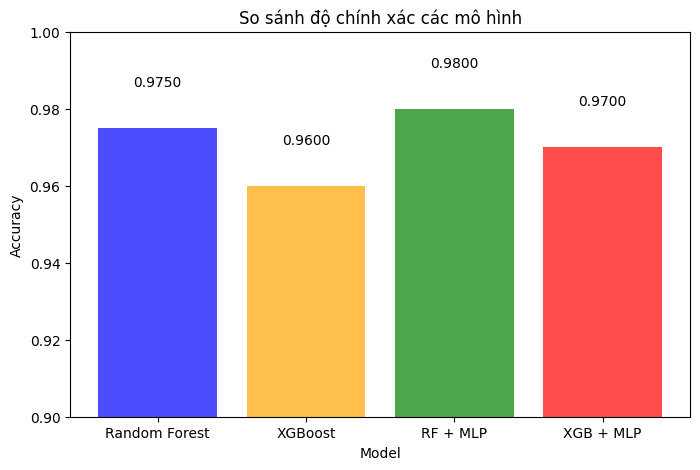

In [ ]:
import matplotlib.pyplot as plt

# Accuracy từng mô hình
accuracies = [
    accuracy,           # RF
    accuracy_xgb,       # XGB
    accuracy_score(y_test, y_pred_rf_mlp),  # RF + MLP
    accuracy_score(y_test, y_pred_xgb_mlp)  # XGB + MLP
]

# Tên các mô hình
model_names = ['Random Forest', 'XGBoost', 'RF + MLP', 'XGB + MLP']

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red'], alpha=0.7)

# Thêm giá trị accuracy lên trên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.4f}", ha='center', va='bottom')

plt.ylim(0.9, 1)
plt.title('So sánh độ chính xác các mô hình')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()


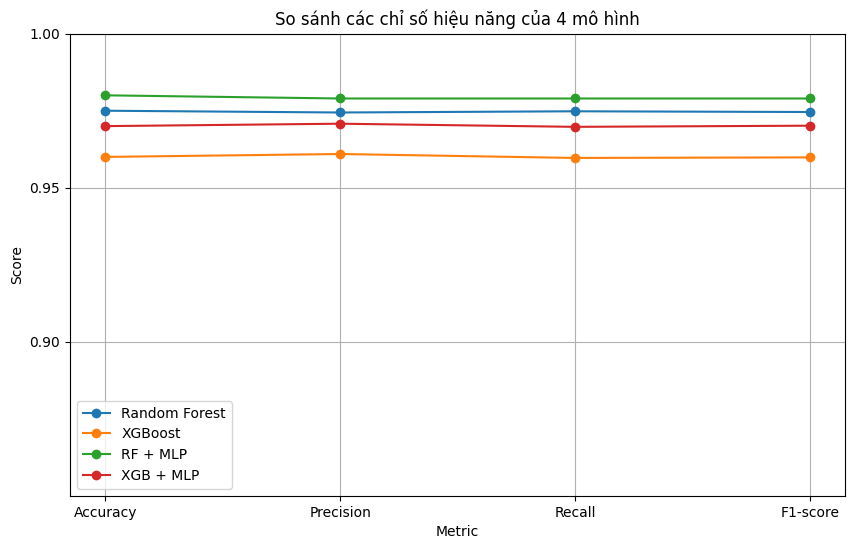

In [ ]:
# Hàm lấy các metric từ classification_report dưới dạng dict
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    return [accuracy, precision, recall, f1]

# Lấy metric từng mô hình
metrics_rf = get_metrics(y_test, y_pred_rf)
metrics_xgb = get_metrics(y_test, y_pred_xgb)
metrics_rf_mlp = get_metrics(y_test, y_pred_rf_mlp)
metrics_xgb_mlp = get_metrics(y_test, y_pred_xgb_mlp)

# Các tên metric
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Vẽ biểu đồ line plot
plt.figure(figsize=(10,6))

plt.plot(metrics_names, metrics_rf, marker='o', label='Random Forest')
plt.plot(metrics_names, metrics_xgb, marker='o', label='XGBoost')
plt.plot(metrics_names, metrics_rf_mlp, marker='o', label='RF + MLP')
plt.plot(metrics_names, metrics_xgb_mlp, marker='o', label='XGB + MLP')

plt.ylim(0.85, 1.00)
plt.yticks(np.arange(0.9, 1.01, 0.05))
plt.title('So sánh các chỉ số hiệu năng của 4 mô hình')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()